In [17]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [22]:
# !unzip "/content/gdrive/MyDrive/IISc_Internship/FER/FER.zip" -d "/content/gdrive/MyDrive/IISc_Internship/FER/Extracted" 

In [1]:
import tensorflow as tf
import keras 
import os
import numpy as np
import datetime
np.random.seed(1)
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.utils.vis_utils import plot_model

dim_colour="darkgrey"
main_accent_colour = "#b366ff"

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# IMG_HEIGHT=64
# IMG_WIDTH=64
# IMG_CHANNELS=1

In [2]:
train_dir ='train/'
test_dir = 'test/'

row = 64
col = 64
classes = 7

In [3]:
print("Train Set :")

train_count = []
for folder in os.listdir(train_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(train_dir+folder)), "image")
    train_count.append(len(os.listdir(train_dir+folder)))
    
print()

test_count = []
print("Test Set :")
for folder in os.listdir(test_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(test_dir+folder)), "images")
    test_count.append(len(os.listdir(test_dir+folder)))

Train Set :
happy folder contains		 7215 image
fear folder contains		 4097 image
neutral folder contains		 4965 image
sad folder contains		 4830 image
disgust folder contains		 436 image
surprise folder contains		 3171 image
angry folder contains		 3995 image

Test Set :
happy folder contains		 1774 images
fear folder contains		 1024 images
neutral folder contains		 1233 images
sad folder contains		 1247 images
disgust folder contains		 111 images
surprise folder contains		 831 images
angry folder contains		 958 images


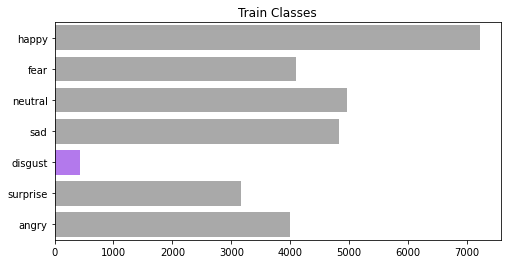

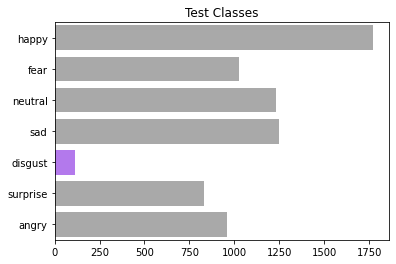

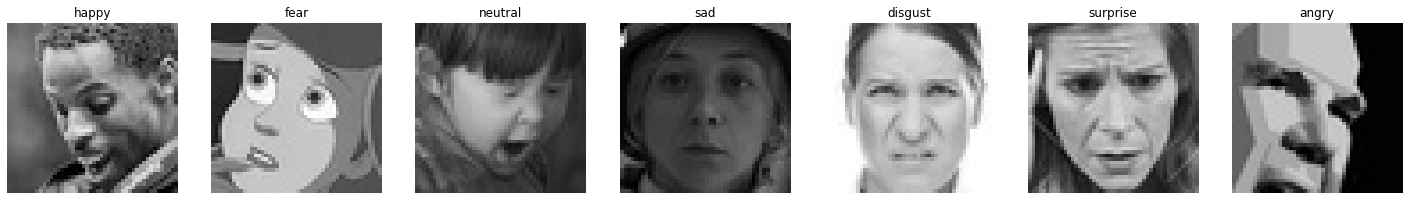

In [4]:
vals = ["disgust"]
palette = {c: dim_colour if c not in vals else main_accent_colour for c in os.listdir(train_dir)}

plt.figure(figsize=(8,4))

ax = sns.barplot(y=os.listdir(train_dir),
                 x=train_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Train Classes')

plt.show()

print()

ax = sns.barplot(y=os.listdir(test_dir),
                 x=test_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Test Classes')

plt.show()

print()

plt.figure(figsize=(25,25))

i = 1
for folder in os.listdir(train_dir):
    
    img = load_img((train_dir + folder +'/'+ os.listdir(train_dir + folder)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(folder)
    plt.axis('off')
    i += 1
    
plt.show()

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(64,64),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(64,64),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [7]:
def get_model(input_size, classes=7):
    
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2),padding='same',strides=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same',strides=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())    
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same',strides=2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())    
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same',strides=2))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
  
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(7,activation='softmax'))

    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [39]:
# inputs=tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
# c11=tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(inputs)
# n11=tf.keras.layers.BatchNormalization(axis=-1)(c11)
# c12=tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same')(n11)
# n12=tf.keras.layers.BatchNormalization(axis=-1)(c12)
# p1=tf.keras.layers.MaxPool2D(pool_size=(2, 2),padding='same',strides=2)(n12)
# d1=tf.keras.layers.Dropout(0.25)(p1)

# c21=tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(d1)
# n21=tf.keras.layers.BatchNormalization(axis=-1)(c21)
# c22=tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same')(n21)
# n22=tf.keras.layers.BatchNormalization(axis=-1)(c22)
# p2=tf.keras.layers.MaxPool2D(pool_size=(2, 2),padding='same',strides=2)(n22)
# d2=tf.keras.layers.Dropout(0.25)(p2)

# c31=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(d2)
# n31=tf.keras.layers.BatchNormalization(axis=-1)(c31)
# c32=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(n31)
# n32=tf.keras.layers.BatchNormalization(axis=-1)(c32)
# c33=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(n32)
# n33=tf.keras.layers.BatchNormalization(axis=-1)(c33)
# p3=tf.keras.layers.MaxPool2D(pool_size=(2, 2),padding='same',strides=2)(n33)
# d3=tf.keras.layers.Dropout(0.25)(p3)


# c41=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(d3)
# n41=tf.keras.layers.BatchNormalization(axis=-1)(c41)
# c42=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(n41)
# n42=tf.keras.layers.BatchNormalization(axis=-1)(c42)
# c43=tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same')(n42)
# n43=tf.keras.layers.BatchNormalization(axis=-1)(c43)
# p4=tf.keras.layers.MaxPool2D(pool_size=(2, 2),padding='same',strides=2)(n43)
# d4=tf.keras.layers.Dropout(0.25)(p4)

# flat=tf.keras.layers.Flatten()(d4)

# fc1=tf.keras.layers.Dense(1024)(flat)
# ac1= tf.keras.layers.Activation('relu')(fc1)
# dfc1=tf.keras.layers.Dropout(rate=0.50)(ac1)

# fc2=tf.keras.layers.Dense(1024)(dfc1)
# ac2= tf.keras.layers.Activation('relu')(fc2)
# dfc2=tf.keras.layers.Dropout(rate=0.50)(ac2)

# # Change the below line for 8 output classes as expected
# fc3=tf.keras.layers.Dense(7)(dfc2)
# outputs=tf.keras.layers.Activation('softmax')(fc3)

# model=tf.keras.Model(inputs=[inputs],outputs=[outputs])
# model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])

# print(model.summary())

In [8]:
fernet = get_model((row,col,1), classes)
fernet.summary()

2022-06-28 10:42:15.978293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-28 10:42:17.191584: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11471 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2
2022-06-28 10:42:17.192774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11481 MB memory:  -> device: 1, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:84:00.0, compute capability: 5.2


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                        

/home/kanda/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [58]:
# plot_model(fernet, show_layer_names=True)

In [9]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_accuracy')

earlystop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [10]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                  validation_data=test_set,
                  epochs=150,
                  callbacks=callbacks,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)

Epoch 1/150


2022-06-28 10:42:28.194642: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2022-06-28 10:42:28.809454: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


448/448 [==============================] - ETA: 0s - loss: 2.0066 - accuracy: 0.2140
Epoch 1: val_loss improved from inf to 1.84034, saving model to ferNet.h5
448/448 [==============================] - 33s 64ms/step - loss: 2.0066 - accuracy: 0.2140 - val_loss: 1.8403 - val_accuracy: 0.2469 - lr: 1.0000e-04
Epoch 2/150
448/448 [==============================] - ETA: 0s - loss: 1.7932 - accuracy: 0.2688
Epoch 2: val_loss improved from 1.84034 to 1.67553, saving model to ferNet.h5
448/448 [==============================] - 28s 62ms/step - loss: 1.7932 - accuracy: 0.2688 - val_loss: 1.6755 - val_accuracy: 0.3422 - lr: 1.0000e-04
Epoch 3/150
448/448 [==============================] - ETA: 0s - loss: 1.7000 - accuracy: 0.3200
Epoch 3: val_loss improved from 1.67553 to 1.56991, saving model to ferNet.h5
448/448 [==============================] - 29s 64ms/step - loss: 1.7000 - accuracy: 0.3200 - val_loss: 1.5699 - val_accuracy: 0.3915 - lr: 1.0000e-04
Epoch 4/150
448/448 [====================

Epoch 27/150
448/448 [==============================] - ETA: 0s - loss: 0.9436 - accuracy: 0.6463
Epoch 27: val_loss improved from 0.98625 to 0.96495, saving model to ferNet.h5
448/448 [==============================] - 30s 67ms/step - loss: 0.9436 - accuracy: 0.6463 - val_loss: 0.9649 - val_accuracy: 0.6426 - lr: 1.0000e-04
Epoch 28/150
448/448 [==============================] - ETA: 0s - loss: 0.9294 - accuracy: 0.6512
Epoch 28: val_loss did not improve from 0.96495
448/448 [==============================] - 30s 67ms/step - loss: 0.9294 - accuracy: 0.6512 - val_loss: 1.0422 - val_accuracy: 0.6140 - lr: 1.0000e-04
Epoch 29/150
448/448 [==============================] - ETA: 0s - loss: 0.9136 - accuracy: 0.6561
Epoch 29: val_loss did not improve from 0.96495
448/448 [==============================] - 30s 67ms/step - loss: 0.9136 - accuracy: 0.6561 - val_loss: 0.9925 - val_accuracy: 0.6377 - lr: 1.0000e-04
Epoch 30/150
448/448 [==============================] - ETA: 0s - loss: 0.9056 - 

448/448 [==============================] - ETA: 0s - loss: 0.6475 - accuracy: 0.7605
Epoch 54: val_loss did not improve from 0.92649
448/448 [==============================] - 30s 67ms/step - loss: 0.6475 - accuracy: 0.7605 - val_loss: 0.9584 - val_accuracy: 0.6671 - lr: 1.0000e-04
Epoch 55/150
448/448 [==============================] - ETA: 0s - loss: 0.6460 - accuracy: 0.7628
Epoch 55: val_loss did not improve from 0.92649
448/448 [==============================] - 30s 67ms/step - loss: 0.6460 - accuracy: 0.7628 - val_loss: 0.9737 - val_accuracy: 0.6695 - lr: 1.0000e-04
Epoch 56/150
448/448 [==============================] - ETA: 0s - loss: 0.6367 - accuracy: 0.7660
Epoch 56: val_loss did not improve from 0.92649
448/448 [==============================] - 30s 67ms/step - loss: 0.6367 - accuracy: 0.7660 - val_loss: 0.9545 - val_accuracy: 0.6766 - lr: 1.0000e-04
Epoch 57/150
448/448 [==============================] - ETA: 0s - loss: 0.6250 - accuracy: 0.7694
Epoch 57: val_loss did not 

448/448 [==============================] - ETA: 0s - loss: 0.4262 - accuracy: 0.8428
Epoch 81: val_loss did not improve from 0.92649
448/448 [==============================] - 30s 67ms/step - loss: 0.4262 - accuracy: 0.8428 - val_loss: 1.0623 - val_accuracy: 0.6864 - lr: 4.0000e-06
Epoch 82/150
448/448 [==============================] - ETA: 0s - loss: 0.4169 - accuracy: 0.8451
Epoch 82: val_loss did not improve from 0.92649
448/448 [==============================] - 30s 67ms/step - loss: 0.4169 - accuracy: 0.8451 - val_loss: 1.0632 - val_accuracy: 0.6895 - lr: 4.0000e-06
Epoch 83/150
448/448 [==============================] - ETA: 0s - loss: 0.4188 - accuracy: 0.8458
Epoch 83: val_loss did not improve from 0.92649
448/448 [==============================] - 30s 66ms/step - loss: 0.4188 - accuracy: 0.8458 - val_loss: 1.0697 - val_accuracy: 0.6881 - lr: 4.0000e-06
Epoch 84/150
448/448 [==============================] - ETA: 0s - loss: 0.4212 - accuracy: 0.8439
Epoch 84: val_loss did not 

Epoch 108/150
448/448 [==============================] - ETA: 0s - loss: 0.4115 - accuracy: 0.8478
Epoch 108: val_loss did not improve from 0.92649
448/448 [==============================] - 30s 67ms/step - loss: 0.4115 - accuracy: 0.8478 - val_loss: 1.0788 - val_accuracy: 0.6843 - lr: 6.4000e-09
Epoch 109/150
448/448 [==============================] - ETA: 0s - loss: 0.4127 - accuracy: 0.8468
Epoch 109: val_loss did not improve from 0.92649
448/448 [==============================] - 30s 67ms/step - loss: 0.4127 - accuracy: 0.8468 - val_loss: 1.0739 - val_accuracy: 0.6850 - lr: 6.4000e-09
Epoch 110/150
448/448 [==============================] - ETA: 0s - loss: 0.4085 - accuracy: 0.8493
Epoch 110: val_loss did not improve from 0.92649
448/448 [==============================] - 30s 67ms/step - loss: 0.4085 - accuracy: 0.8493 - val_loss: 1.0784 - val_accuracy: 0.6840 - lr: 6.4000e-09
Epoch 111/150
448/448 [==============================] - ETA: 0s - loss: 0.4174 - accuracy: 0.8462
Epoch 1

448/448 [==============================] - 30s 67ms/step - loss: 0.4082 - accuracy: 0.8507 - val_loss: 1.0780 - val_accuracy: 0.6851 - lr: 1.0240e-11
Epoch 135/150
448/448 [==============================] - ETA: 0s - loss: 0.4116 - accuracy: 0.8490
Epoch 135: val_loss did not improve from 0.92649
448/448 [==============================] - 30s 66ms/step - loss: 0.4116 - accuracy: 0.8490 - val_loss: 1.0772 - val_accuracy: 0.6851 - lr: 1.0240e-11
Epoch 136/150
448/448 [==============================] - ETA: 0s - loss: 0.4076 - accuracy: 0.8493
Epoch 136: val_loss did not improve from 0.92649

Epoch 136: ReduceLROnPlateau reducing learning rate to 2.0479997905886727e-12.
448/448 [==============================] - 30s 66ms/step - loss: 0.4076 - accuracy: 0.8493 - val_loss: 1.0774 - val_accuracy: 0.6861 - lr: 1.0240e-11
Epoch 137/150
448/448 [==============================] - ETA: 0s - loss: 0.4051 - accuracy: 0.8511
Epoch 137: val_loss did not improve from 0.92649
448/448 [=================

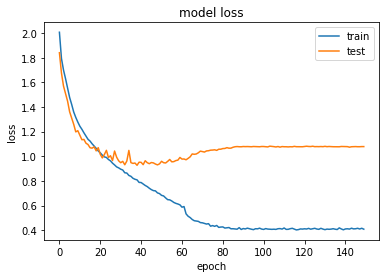

In [11]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

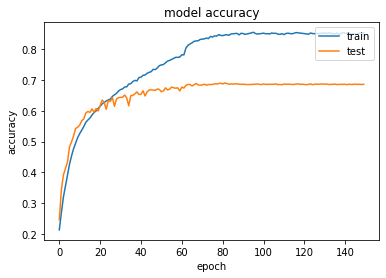

In [12]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [13]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 2s 20ms/step - loss: 1.0778 - accuracy: 0.6854
final train accuracy = 89.93 , validation accuracy = 68.54


449/449 [==============================] - 21s 47ms/step
Confusion Matrix
[[ 558   77  563  969  736  656  436]
 [  63    6   67   98   92   59   51]
 [ 539   66  534 1060  758  679  461]
 [ 961  110  979 1863 1282 1191  829]
 [ 687   86  661 1273  904  782  572]
 [ 642   70  639 1224  869  822  564]
 [ 416   53  450  830  551  534  337]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3995
     disgust       0.01      0.01      0.01       436
        fear       0.14      0.13      0.13      4097
       happy       0.25      0.26      0.26      7215
     neutral       0.17      0.18      0.18      4965
         sad       0.17      0.17      0.17      4830
    surprise       0.10      0.11      0.10      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



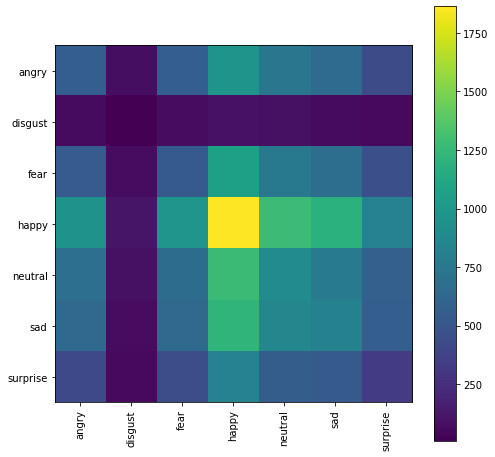

In [14]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)